In [ ]:
### AWFUL ATTEMPT AT MIN. MSE.

In [88]:
import random
import numpy as np

from sklearn import datasets

from deap import base, creator, tools

In [89]:
X, y = datasets.make_regression()
X = np.sum(X, axis=1)

In [90]:
def get_value(individual):
    def to_int(b):
        return int(b, 2)

    t = individual[:8]
    b = individual[8:]

    t_i = float(to_int(
        ''.join((str(xi) for xi in t))))

    b_i = float(to_int(
        ''.join((str(xi) for xi in b))))

    if b_i == 0:
        return t_i

    return t_i + (1/b_i)
    
def COST(individual):
        
    m = get_value(individual[:16])
    b = get_value(individual[16:])
    
    y_hat = m*X + b
    return np.mean( np.square( y - y_hat ) ),

In [91]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

C:\Users\dmpas\Anaconda3\lib\site-packages\deap\creator.py:141: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
C:\Users\dmpas\Anaconda3\lib\site-packages\deap\creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


In [92]:
tbx = base.Toolbox()

In [93]:
INDIVIDUAL_SIZE = 32

tbx.register("attr_int", random.randint, 0, 1)
tbx.register("individual", 
             tools.initRepeat, 
             creator.Individual,
             tbx.attr_int, 
             n=INDIVIDUAL_SIZE)

tbx.register("population", tools.initRepeat, list, tbx.individual)

In [94]:
tbx.register("evaluate", COST)

def CROSSOVER(ind1, ind2):
    i1, i2 = tools.cxOnePoint(ind1[:8], ind2[:8])
    i3, i4 = tools.cxOnePoint(ind1[8:], ind2[8:])
    
    return creator.Individual(np.concatenate((i1, i3))), \
        creator.Individual(np.concatenate((i2, i4)))
    

tbx.register("mate", CROSSOVER)
tbx.register("mutate", tools.mutFlipBit, indpb=0.5)
tbx.register("select", tools.selTournament, tournsize=5)

In [95]:
def set_fitness(population):
    fitnesses = [ 
        (individual, tbx.evaluate(individual)) 
        for individual in population 
    ]

    for individual, fitness in fitnesses:
        individual.fitness.values = fitness
        
def pull_stats(population, iteration=1):
    fitnesses = [ individual.fitness.values[0] for individual in population ]
    return {
        'i': iteration,
        'mu': np.mean(fitnesses),
        'std': np.std(fitnesses),
        'max': np.max(fitnesses),
        'min': np.min(fitnesses)
    }

In [96]:
## create random population,
population = tbx.population(n=200)

## set fitness,
set_fitness(population)

In [97]:
## globals,
stats = []

In [98]:
iteration = 1
while iteration < 500:
    
    current_population = list(map(tbx.clone, population))
    
    offspring = []
    for _ in range(50):
        i1, i2 = np.random.choice(range(len(population)), size=2, replace=False)

        offspring1, offspring2 = \
            tbx.mate(population[i1], population[i2])

        offspring.append(tbx.mutate(offspring1)[0])
        offspring.append(tbx.mutate(offspring2)[0])  
    
    for child in offspring:
        current_population.append(child)

    ## reset fitness,
    set_fitness(current_population)

    population[:] = tbx.select(current_population, len(population))
    
    ## set fitness on individuals in the population,
    stats.append(
        pull_stats(population, iteration))
    
    iteration += 1

In [99]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()

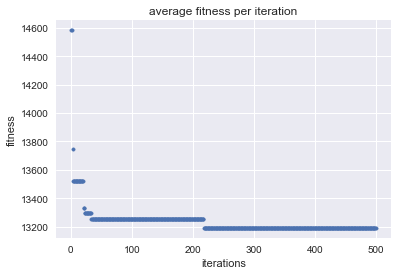

In [100]:
_ = plt.scatter(range(1, len(stats)+1), [ s['min'] for s in stats ], marker='.')

_ = plt.title('average fitness per iteration')
_ = plt.xlabel('iterations')
_ = plt.ylabel('fitness')

plt.show()

In [101]:
def pp_plt(X, y, b, m):
    
    _ = plt.scatter(X, y)
    
    # regression stats,
    _ = plt.plot(X, X*m + b, color='r')
    
    plt.show()

In [102]:
best_individuals = sorted([ 
    (i, individual, get_value(individual)) 
    for i, individual in enumerate(population) 
][:10], key=lambda x: x[1], reverse=False)

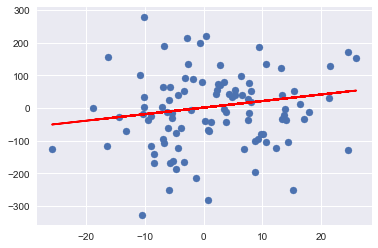

m: 2.006666666666667 b: 1.0116279069767442


In [103]:
m = get_value(best_individuals[0][1][:16])
b = get_value(best_individuals[0][1][16:])

pp_plt(X, y, b, m)

print('m:', m, 'b:', b)

In [104]:
COST(best_individuals[0][1])

(13190.762971339102,)